In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# Plot Time Series Graph
def plot_time_series(time, series, format='-', start=0, end=None, label=None):
  plt.plot(time[start:end], series[start:end], format, label=label)
  plt.xlabel('Time')
  plt.ylabel('Value')
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)  

# To generate trend
def trend(time, slope=0):
  return time * slope

# To generate Seasonal Pattern
def seasonal_pattern(season_time):
  return np.where(season_time < 0.4,
                  np.cos(season_time * 2 * np.pi),
                  1 / np.exp(3 * season_time))
  
# To generate seasonality data
def seasonality(time, period, amplitude=1, phase=0):
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)

# To generate noise
def white_noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level


def window_dataset(series, window_size, batch_size=32, shuffle_buffer=1000):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(size=window_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
  dataset = dataset.shuffle(shuffle_buffer)
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  
  return dataset


def model_forecast(model, series, window_size):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda w: w.batch(window_size))
  dataset = dataset.batch(32).prefetch(1)
  forecast = model.predict(dataset)

  return forecast

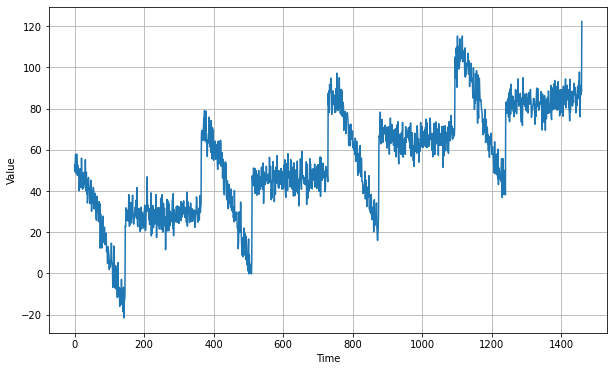

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level=noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_time_series(time, series)
plt.show()

In [4]:
split_time = 1000

time_train = time[:split_time]
time_valid = time[split_time:]

x_train = series[:split_time]
x_valid = series[split_time:]

In [5]:
x_train.shape, x_valid.shape

((1000,), (461,))

# Stateful RNN Forecasting

In [6]:
def sequential_window_dataset(series, window_size):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size+1, shift=window_size, drop_remainder=True)
  dataset = dataset.flat_map(lambda w: w.batch(window_size+1))
  dataset = dataset.map(lambda w: (w[:-1], w[1:]))
  dataset = dataset.batch(1).prefetch(1)

  return dataset

In [7]:
for X_batch, y_batch in sequential_window_dataset(tf.range(10), 3):
    print(X_batch.numpy(), y_batch.numpy())

[[[0]
  [1]
  [2]]] [[[1]
  [2]
  [3]]]
[[[3]
  [4]
  [5]]] [[[4]
  [5]
  [6]]]
[[[6]
  [7]
  [8]]] [[[7]
  [8]
  [9]]]


In [8]:
class ResetStatesCallback(tf.keras.callbacks.Callback):
  def on_epoch_begin(self, epoch, logs):
    self.model.reset_states()

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

WINDOW_SIZE = 30
train_set = sequential_window_dataset(x_train, WINDOW_SIZE)

model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(100, return_sequences=True, stateful=True, batch_input_shape=[1, None, 1]),
    tf.keras.layers.SimpleRNN(100, stateful=True, return_sequences=True),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*200)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/30)
)

model.compile(
    loss = tf.keras.losses.Huber(),
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9),
    metrics = ['mae']
)

history = model.fit(train_set,
                    epochs=100,
                    callbacks=[lr_schedule])

Epoch 1/100
33/33 [==============================] - 5s 50ms/step - loss: 105.9340 - mae: 106.4339
Epoch 2/100
33/33 [==============================] - 2s 49ms/step - loss: 70.6315 - mae: 71.1315
Epoch 3/100
33/33 [==============================] - 2s 46ms/step - loss: 39.5356 - mae: 40.0325
Epoch 4/100
33/33 [==============================] - 2s 49ms/step - loss: 27.0279 - mae: 27.5232
Epoch 5/100
33/33 [==============================] - 2s 49ms/step - loss: 24.2041 - mae: 24.6980
Epoch 6/100
33/33 [==============================] - 2s 46ms/step - loss: 22.9721 - mae: 23.4644
Epoch 7/100
33/33 [==============================] - 2s 47ms/step - loss: 21.7609 - mae: 22.2534
Epoch 8/100
33/33 [==============================] - 2s 54ms/step - loss: 20.5610 - mae: 21.0534
Epoch 9/100
33/33 [==============================] - 2s 47ms/step - loss: 19.5427 - mae: 20.0364
Epoch 10/100
33/33 [==============================] - 2s 51ms/step - loss: 18.6547 - mae: 19.1470
Epoch 11/100
33/33 [=======

(1e-08, 0.0001, 0.0, 30.0)

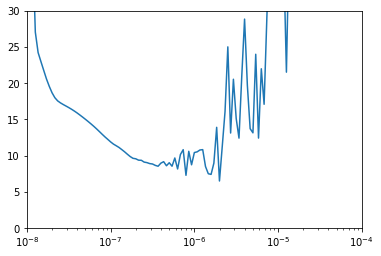

In [10]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

WINDOW_SIZE = 30
train_set = sequential_window_dataset(x_train, WINDOW_SIZE)
valid_set = sequential_window_dataset(x_valid, WINDOW_SIZE)

model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(100, return_sequences=True, stateful=True, batch_input_shape=[1, None, 1]),
    tf.keras.layers.SimpleRNN(100, stateful=True, return_sequences=True),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*200)
])

model.compile(
    loss = tf.keras.losses.Huber(),
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9),
    metrics = ['mae']
)

reset_states = ResetStatesCallback()
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'my_checkpoint.h5', save_best_only=True
)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=50)


history = model.fit(train_set,
                    epochs=100,
                    validation_data=valid_set,
                    callbacks=[early_stopping,
                               model_checkpoint,
                               reset_states])

Epoch 1/100
33/33 [==============================] - 4s 70ms/step - loss: 60.2497 - mae: 60.7477 - val_loss: 25.0215 - val_mae: 25.5176
Epoch 2/100
33/33 [==============================] - 2s 58ms/step - loss: 21.4714 - mae: 21.9618 - val_loss: 10.9142 - val_mae: 11.4074
Epoch 3/100
33/33 [==============================] - 2s 67ms/step - loss: 18.7249 - mae: 19.2167 - val_loss: 12.0569 - val_mae: 12.5479
Epoch 4/100
33/33 [==============================] - 2s 54ms/step - loss: 17.5231 - mae: 18.0143 - val_loss: 10.4488 - val_mae: 10.9391
Epoch 5/100
33/33 [==============================] - 2s 53ms/step - loss: 16.6983 - mae: 17.1891 - val_loss: 9.9581 - val_mae: 10.4499
Epoch 6/100
33/33 [==============================] - 2s 56ms/step - loss: 15.9090 - mae: 16.3984 - val_loss: 9.1539 - val_mae: 9.6415
Epoch 7/100
33/33 [==============================] - 2s 67ms/step - loss: 15.2155 - mae: 15.7027 - val_loss: 8.3393 - val_mae: 8.8248
Epoch 8/100
33/33 [==============================] - 

In [12]:
model = tf.keras.models.load_model("my_checkpoint.h5")

In [13]:
model.reset_states()
model_forecast = model.predict(series[np.newaxis, :, np.newaxis])
model_forecast = model_forecast[0, split_time - 1:-1, 0]

In [14]:
model_forecast.shape

(461,)

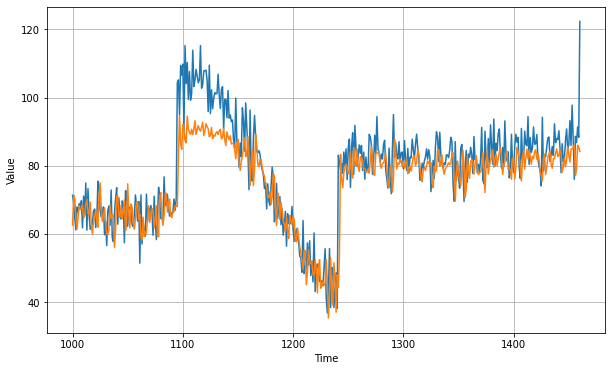

In [15]:
plt.figure(figsize=(10, 6))
plot_time_series(time_valid, x_valid)
plot_time_series(time_valid, model_forecast)

In [16]:
model_forecast_mae = tf.keras.metrics.mean_absolute_error(x_valid, model_forecast)
model_forecast_mae

<tf.Tensor: shape=(), dtype=float32, numpy=6.2778244>